In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
np.set_printoptions(threshold=np.inf)
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#E33C21", "#7C3327", "#CE9B2D", "#7B5B17", "#B6D22D", "#FBF704", "#40FB04", "#42852D", "#03FFB3", "#3486C6", "#0E1CEC", "#BA0EEC"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
cases = pd.read_csv('time_series_covid19_confirmed.csv')
cases = cases.drop(columns = ['Province/State','Lat','Long'])
country_cases = cases.groupby(['Country/Region'],as_index=False).agg('sum')

# plot confirmed case for some country

In [4]:
China = country_cases.loc[country_cases['Country/Region'] == 'China'] 
China = China.iloc[0,1:]
China.index = pd.to_datetime(China.index)

In [5]:
Japan = country_cases.loc[country_cases['Country/Region'] == 'Japan'] 
Japan = Japan.iloc[0,1:]
Japan.index = pd.to_datetime(Japan.index)

In [6]:
Italy = country_cases.loc[country_cases['Country/Region'] == 'Italy'] 
Italy = Italy.iloc[0,1:]
Italy.index = pd.to_datetime(Italy.index)

In [7]:
US = country_cases.loc[country_cases['Country/Region'] == 'US'] 
US = US.iloc[0,1:]
US.index = pd.to_datetime(US.index)

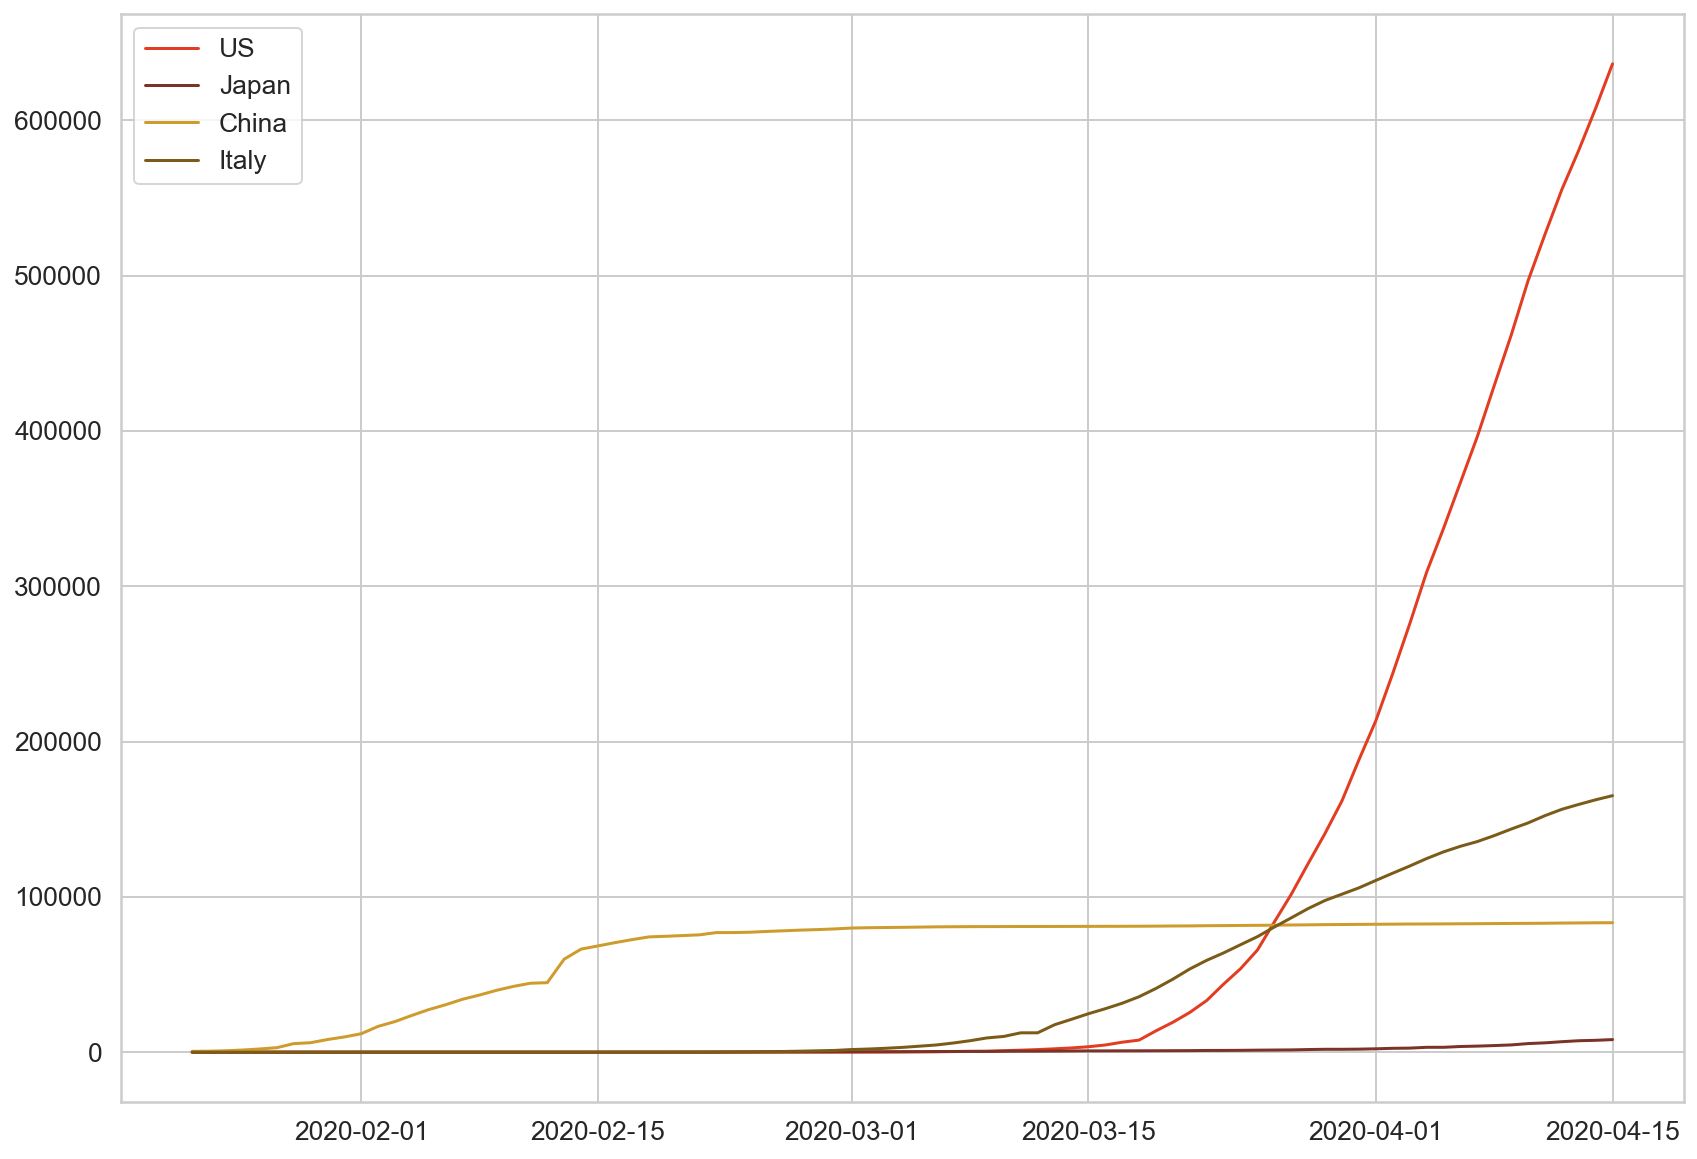

In [10]:
plt.plot(US, label='US')
plt.plot(Japan, label='Japan')
plt.plot(China, label='China')
plt.plot(Italy, label='Italy')
plt.legend()

# Model for single country

In [18]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
cases = country_cases.loc[country_cases['Country/Region'] == 'United Kingdom'] 
cases = cases.drop(columns = ['Country/Region'])
cases = cases.astype('float64')
dataset = cases.to_numpy()[0]

In [20]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset[:, np.newaxis])

In [21]:
test_data_size = 10
train = dataset[:-test_data_size]
test = dataset[-test_data_size:]

In [22]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=70, batch_size=1, verbose=2)

Epoch 1/70
 - 1s - loss: 0.0073
Epoch 2/70
 - 0s - loss: 0.0062
Epoch 3/70
 - 0s - loss: 0.0054
Epoch 4/70
 - 0s - loss: 0.0046
Epoch 5/70
 - 0s - loss: 0.0038
Epoch 6/70
 - 0s - loss: 0.0030
Epoch 7/70
 - 0s - loss: 0.0022
Epoch 8/70
 - 0s - loss: 0.0016
Epoch 9/70
 - 0s - loss: 0.0011
Epoch 10/70
 - 0s - loss: 6.8015e-04
Epoch 11/70
 - 0s - loss: 3.9221e-04
Epoch 12/70
 - 0s - loss: 2.2970e-04
Epoch 13/70
 - 0s - loss: 1.3137e-04
Epoch 14/70
 - 0s - loss: 8.1965e-05
Epoch 15/70
 - 0s - loss: 6.1792e-05
Epoch 16/70
 - 0s - loss: 5.2200e-05
Epoch 17/70
 - 0s - loss: 5.0624e-05
Epoch 18/70
 - 0s - loss: 4.6746e-05
Epoch 19/70
 - 0s - loss: 4.6299e-05
Epoch 20/70
 - 0s - loss: 4.5650e-05
Epoch 21/70
 - 0s - loss: 4.6712e-05
Epoch 22/70
 - 0s - loss: 4.6507e-05
Epoch 23/70
 - 0s - loss: 4.5181e-05
Epoch 24/70
 - 0s - loss: 4.3826e-05
Epoch 25/70
 - 0s - loss: 4.3815e-05
Epoch 26/70
 - 0s - loss: 4.1548e-05
Epoch 27/70
 - 0s - loss: 4.3522e-05
Epoch 28/70
 - 0s - loss: 4.1080e-05
Epoch 29/

In [23]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 333.43 RMSE
Test Score: 11614.26 RMSE


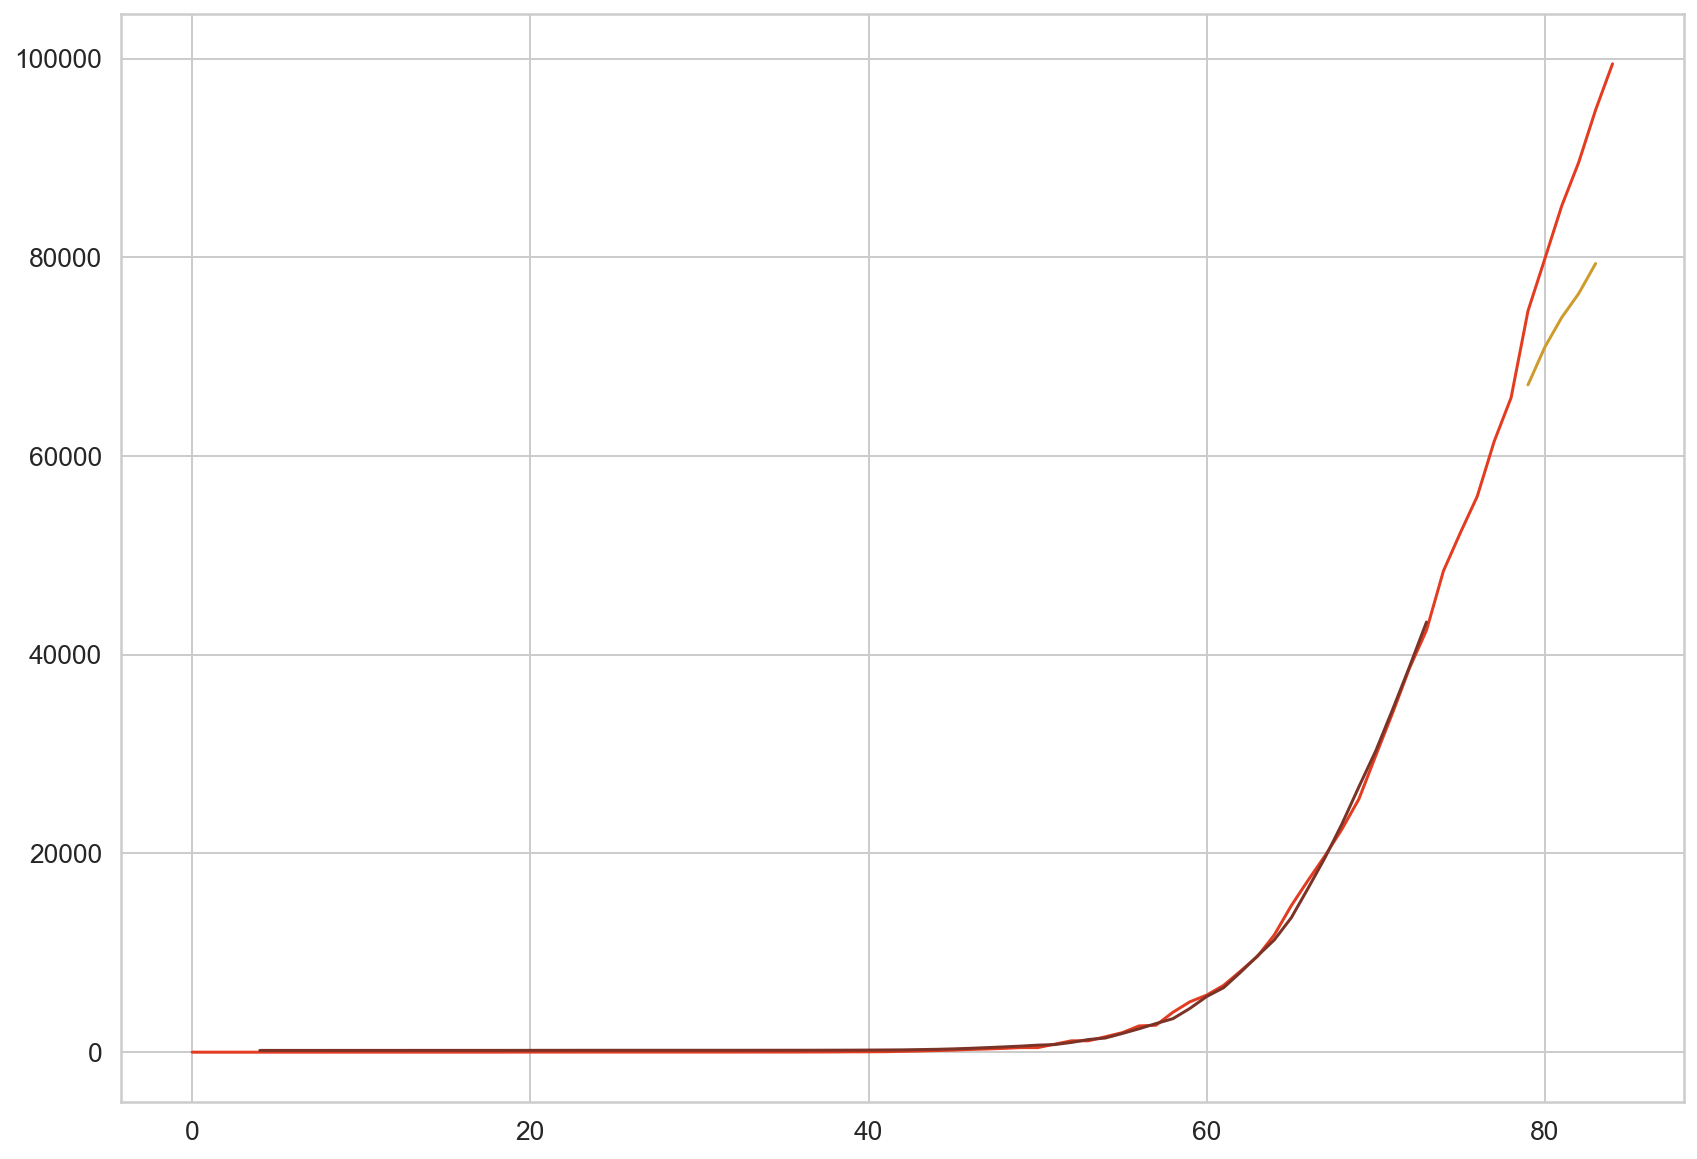

In [24]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# for global

## normalize the data by considering population density

In [27]:
population_density = pd.read_csv('population_density.csv')
population_density['Density'] = population_density['Density'].str.replace(',','').astype(float)
country_cases_density = country_cases.set_index('Country/Region').join(population_density.set_index('Country (or dependent territory)'))

# filter out some countryies that don't have many cases
filter1 = country_cases_density.iloc[:,-2]>1000
country_cases_density.where(filter1, inplace = True)
country_cases_density = country_cases_density.dropna(how = 'all')
country_cases_density_backup = country_cases_density
# country_cases_density = country_cases_density.drop(['Russia','Czechia'])
country_cases_density.dropna(subset = ["Density"], inplace=True)

# country_cases_density.iloc[0,50]
for i in range(country_cases_density.shape[1]-1):
    country_cases_density.iloc[:,i] = country_cases_density.iloc[:,i]/country_cases_density.iloc[:,-1]

country_density_without_dcolumn = country_cases_density.drop(columns = ['Density'])
# store index of country
countryMap = {}
length = len(country_density_without_dcolumn.index)
for i in range(length):
    countryMap[country_density_without_dcolumn.index[i]] = i

## train model

In [28]:
global_dataset = country_density_without_dcolumn.to_numpy() # convert dataframe to numpy

In [29]:
def create_dataset_global(dataset, look_back=1):
    dataX, dataY = [], []
    for j in range(dataset.shape[0]):
        for i in range(dataset.shape[1]-look_back-1):
            a = dataset[j,i:(i+look_back)]
            if a.any():
                dataX.append(a)
                dataY.append(dataset[j,i + look_back])
    return np.array(dataX), np.array(dataY)

In [30]:
scaler_global = MinMaxScaler(feature_range=(0,1))
global_dataset_scale = scaler_global.fit_transform(global_dataset.flatten()[:, np.newaxis])
global_dataset_scale = np.reshape(global_dataset_scale,(global_dataset.shape[0],global_dataset.shape[1]))

In [31]:
###### for future predictions #######
# putting all data in just training
look_back = 7 #lag time for covid-19 (between the time of actual infection to when the patient was diagnosed and case recorded)
trainX, trainY = create_dataset_global(global_dataset_scale, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [32]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=70, batch_size=1, verbose=2)

Epoch 1/70
 - 14s - loss: 1.5895e-04
Epoch 2/70
 - 14s - loss: 3.0085e-05
Epoch 3/70
 - 14s - loss: 3.1084e-05
Epoch 4/70
 - 14s - loss: 1.9581e-05
Epoch 5/70
 - 14s - loss: 2.1490e-05
Epoch 6/70
 - 14s - loss: 1.5171e-05
Epoch 7/70
 - 14s - loss: 1.6835e-05
Epoch 8/70
 - 13s - loss: 1.4465e-05
Epoch 9/70
 - 13s - loss: 1.2115e-05
Epoch 10/70
 - 14s - loss: 1.3947e-05
Epoch 11/70
 - 14s - loss: 1.2450e-05
Epoch 12/70
 - 14s - loss: 1.2457e-05
Epoch 13/70
 - 15s - loss: 9.9986e-06
Epoch 14/70
 - 14s - loss: 9.4986e-06
Epoch 15/70
 - 14s - loss: 1.1612e-05
Epoch 16/70
 - 14s - loss: 1.0980e-05
Epoch 17/70
 - 15s - loss: 1.0800e-05
Epoch 18/70
 - 15s - loss: 9.8481e-06
Epoch 19/70
 - 15s - loss: 9.4655e-06
Epoch 20/70
 - 14s - loss: 1.0906e-05
Epoch 21/70
 - 14s - loss: 1.4186e-05
Epoch 22/70
 - 13s - loss: 1.2061e-05
Epoch 23/70
 - 13s - loss: 1.0606e-05
Epoch 24/70
 - 14s - loss: 8.5910e-06
Epoch 25/70
 - 14s - loss: 7.3767e-06
Epoch 26/70
 - 14s - loss: 5.7432e-06
Epoch 27/70
 - 15s - 

## test model with single country

In [33]:
# ### for regular train and testing ####
def calRMSE(countryName, model):
    train = global_dataset_scale[countryMap[countryName],:]

    train = np.reshape(train, (len(train),1))

    trainX, trainY = create_dataset(train, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

    # make predictions
    trainPredict = model.predict(trainX)

    # invert predictions
    trainPredict = scaler_global.inverse_transform(trainPredict)
    trainY = scaler_global.inverse_transform([trainY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

    return trainScore

In [34]:
#### for future predictions ####
def createInput(prevInput, output, look_back=7):
    prevInput = prevInput.tolist()
    prevInput.append(output.item())
    newInput = prevInput[-look_back:]
    newInput_np = np.reshape(newInput, (len(newInput),1))
    newInput_ = []
    newInput_.append(newInput_np[:])
    newInput_ = np.array(newInput_)
    newInput_ = np.reshape(newInput_, (newInput_.shape[0], 1, newInput_.shape[1]))
    return newInput_, newInput

def futureModelSingleCountry(countryName, model):
#     testing = global_dataset_scale[countryMap[countryName],-1:]
#     print(testing)
#     testing_ = []
#     testing_.append(testing)
#     testing_ = np.array(testing_)
#     testing_ = scaler_global.inverse_transform(testing_)
#     print(testing_.item()*145)
#     print(look_back)
    start = global_dataset_scale[countryMap[countryName],-look_back:]
    start_ = np.reshape(start, (len(start),1))
    startX = []
    startX.append(start_[:])
    startX = np.array(startX)
    startX = np.reshape(startX, (startX.shape[0], 1, startX.shape[1]))
#     print(startX.shape[0])
#     print(startX)

    # taking last 4 case count as first vector for input (march 27-30)
    predictFor = 30 # predict for future 30 days (predict for month of april)
    futureCaseCnts = []
    for d in range(predictFor):
        d_predict = model.predict(startX)
        startX, start = createInput(start,d_predict)
#         print(startX)
#         print(start)
        start = np.array(start)
#         print(d_predict.item())
        d_predict = scaler_global.inverse_transform(d_predict)
        futureCaseCnts.append(d_predict.item())
    return futureCaseCnts

In [35]:
def future_prediction(which_country, model):
    future_case_cnts = futureModelSingleCountry(which_country, model)
    density = country_cases_density_backup['Density'][countryMap[which_country]]
#     print(density)
    future_case_cnts = np.array(future_case_cnts) * density

    # print(country_cases_density_backup['Density'][countryMap['China']])
    # print(countryMap)
#     print(future_case_cnts)
    futureDates = np.arange(np.datetime64('2020-04-15'), np.datetime64('2020-05-15'))
    # print(futureDates)

    futurePredictseries = pd.Series(future_case_cnts, index=futureDates)
    # future_case_cnts = future_case_cnts[future_case_cnts >= 0]
    maxCaseCntIdx = np.argmax(futurePredictseries)
    maxCaseCnt = np.amax(futurePredictseries)
#     print(maxCaseCntIdx)

    if maxCaseCntIdx+1 != len(futurePredictseries):
        for i in range(maxCaseCntIdx+1,len(futurePredictseries)):
            futurePredictseries[i] = maxCaseCnt

    # futurePredictseries = futurePredictseries[futurePredictseries >= 0]
#     print(futurePredictseries)
    return futurePredictseries

In [36]:
def plotFuture(countryName,futurePredict):
    country = country_cases.loc[country_cases['Country/Region'] == countryName] 
    country = country.iloc[0,1:]
    country.index = pd.to_datetime(country.index)
#     print(country)
    plt.plot(country, label=countryName+' - known')
    plt.plot(futurePredict, label=countryName+' - future')

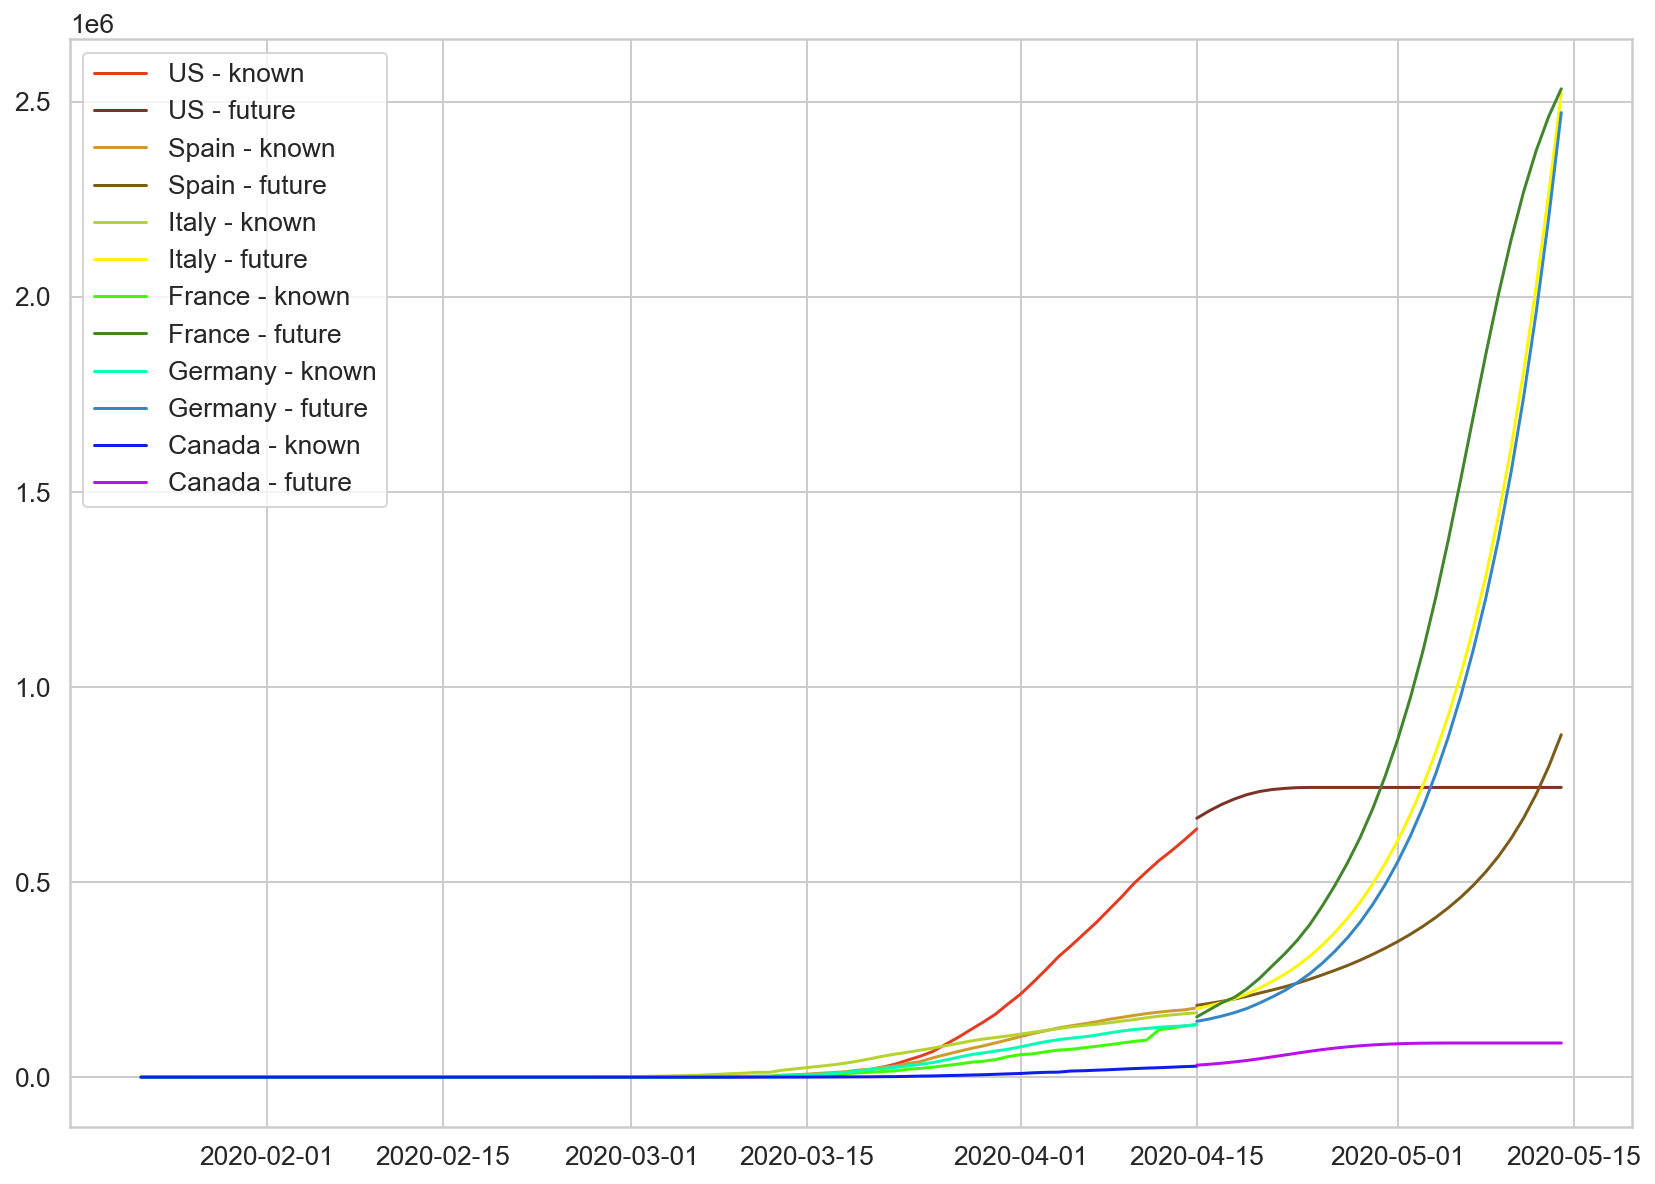

In [37]:
futurePredictseries_us = future_prediction('US', model)
plotFuture('US', futurePredictseries_us)
futurePredictseries_spain = future_prediction('Spain', model)
plotFuture('Spain', futurePredictseries_spain)
futurePredictseries_italy = future_prediction('Italy', model)
plotFuture('Italy', futurePredictseries_italy)
futurePredictseries_uk = future_prediction('France', model)
plotFuture('France', futurePredictseries_uk)
futurePredictseries_uk = future_prediction('Germany', model)
plotFuture('Germany', futurePredictseries_uk)
# futurePredictseries_uk = future_prediction('United Kingdom', model)
# plotFuture('United Kingdom', futurePredictseries_uk)
# futurePredictseries_uk = future_prediction('China', model)
# plotFuture('China', futurePredictseries_uk)
# futurePredictseries_uk = future_prediction('Iran', model)
# plotFuture('Iran', futurePredictseries_uk)
futurePredictseries_uk = future_prediction('Canada', model)
plotFuture('Canada', futurePredictseries_uk)

plt.legend()

In [38]:
trainScore = calRMSE('US', model)

# calculate root mean squared error
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 198.13 RMSE
